In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 사용할 모델 지정
COCO와 MPI는 바디 포즈 추정 모델이다. COCO는 18점, MPI는 15점 출력이다.

HAND는 핸드 키포인트 추정 모델이다. 출력은 22점입니다.

폴더에서 모델 파일을 사용할 수 있는지 확인합니다.

MPII Human Pose : 약 4만 명의 인물이 포함된 2만 5천 장의 이미지로 구성된 데이터 셋이다. 이미지는 유튜브 비디오에서 추출되었다.  
                  각 이미지에는 관절 좌표 뿐만 아니라 신체 부분 폐색, 3D torso and head 방향, 410개의 활동 레이블링이 제공된다.
                    
MS COCO : 약 15만 명의 인물이 포함된 6만장의 이미지로 구성된 데이터 셋이다.

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\MIRACL~1\AppData\Local\Temp/ipykernel_13576/4226963025.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if MODE is "COCO":
C:\Users\MIRACL~1\AppData\Local\Temp/ipykernel_13576/4226963025.py:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif MODE is "MPI" :


#### 여러 사람이 있는 이미지를 로드하고 모델이 보는 것을 확인하겠습니다.

In [3]:
image1 = cv2.imread("multiple.jpeg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

#### 네트워크를 로드하고 네트워크를 통해 이미지 전달

In [4]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 46, 46)


#### 특정 키포인트에 대한 출력에서 확률 맵을 잘라 이미지 자체에 열 맵(크기 조정 후)을 표시합니다.

(-0.5, 1279.5, 1071.5, -0.5)

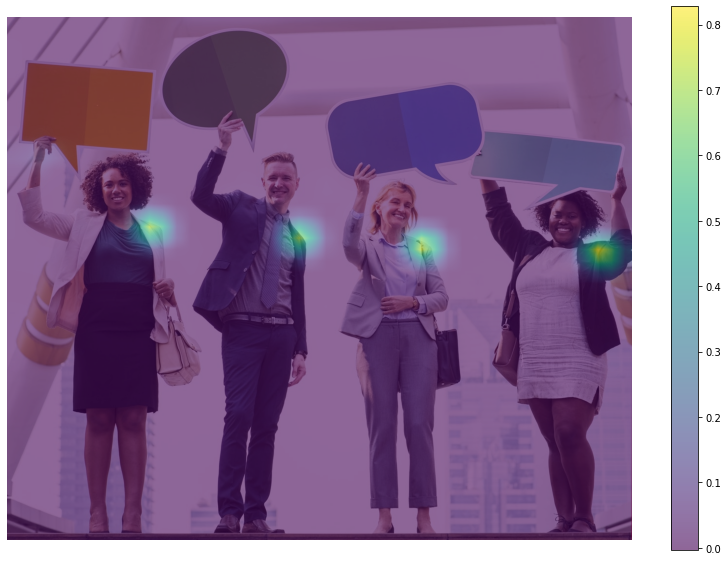

In [5]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### 이미지에 선호도 맵도 유사하게 플롯합니다.

(-0.5, 1279.5, 1071.5, -0.5)

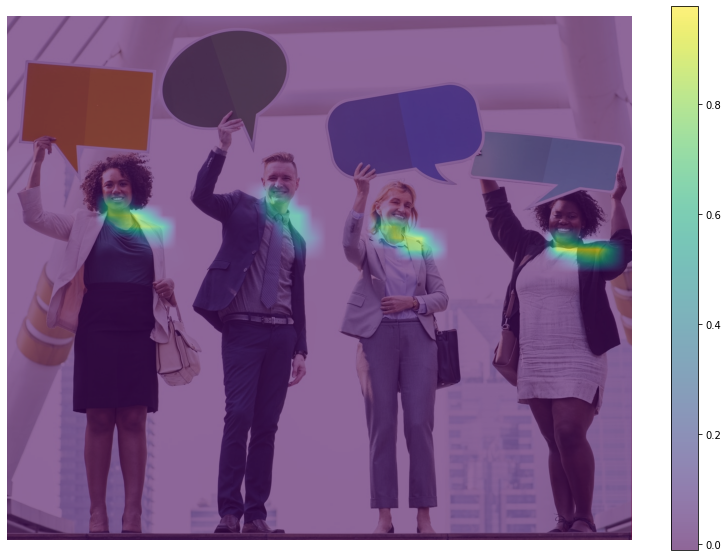

In [6]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### 다음으로, 우리는 한 사람만 있는 이미지의 요점을 찾는다.

In [7]:
import math

def distance(x1, y1, x2, y2):
    result = math.sqrt( math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2))
    return result

body_sizes = []
body_sizes_cap=[]
body_lines=[[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,14],[14,8],[8,9],[9,10],[14,11],[11,12],[12,13]]



for i in range(1,104):
    frame = cv2.imread('./image_woman/w ('+str(i)+').jpeg')
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    # 네트워크를 통해 전달

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
    
    net.setInput(inpBlob)

    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]
    
    # 요점을 종합하여 요점과 해골상을 도표로 나타내다

    # 탐지된 키포인트를 저장할 빈 목록
    points = []

    for i in range(nPoints):
        # 해당 신체 부위의 신뢰도
        probMap = output[0, i, :, :]

        # probMap의 전역 최대값을 찾습니다.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
        # 원래 이미지에 맞게 점의 배율 조정
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

            # 확률이 분계점보다 큰 경우 점 추가
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # 골격 그리기
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
            

    # 점과 점 사이의 거리 구하는 함수
    for pair in body_lines:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            # 두 점의 좌표를 정한다.
            P1 = (points[partA][0], points[partA][1])
            P2 = (points[partB][0], points[partB][1])

            #함수 호출
            d = distance(P1[0], P1[1], P2[0], P2[1])
        
            body_sizes.append(d)


#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.figure(figsize=[10,10])  
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))  
plt.figure(figsize=[10,10])  
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  

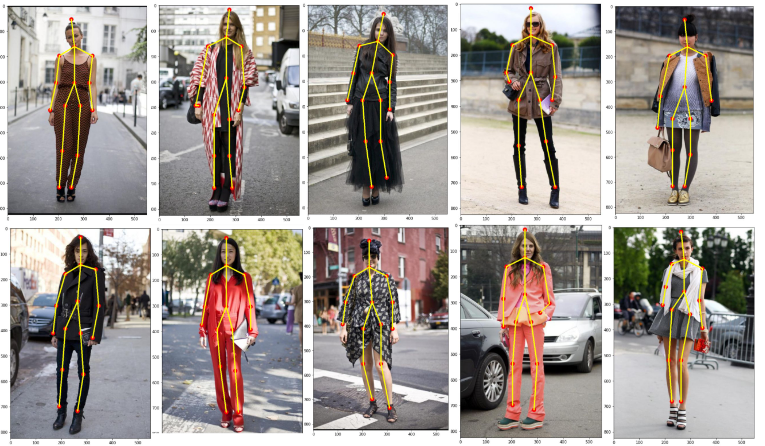

In [8]:
import numpy as np
ret = np.array(body_sizes)
ret.shape

(1442,)

#### 14가지의 신체 부위별 사이즈를 리스트에 담는다.

In [9]:
cnt = 0
fourteen = []
for i in body_sizes:
    cnt+=1
    fourteen.append(i)
    if cnt%14 == 0:
        body_sizes_cap.append(fourteen)
        fourteen = [] 
print(body_sizes_cap)

[[38.0, 28.319604517012593, 38.3275357934736, 10.0, 31.400636936215164, 38.2099463490856, 32.0, 57.0, 39.05124837953327, 51.62363799656123, 57.14017850864661, 39.84971769034255, 51.15662224971465, 63.12685640834652], [39.05124837953327, 21.840329667841555, 46.84015371452148, 19.6468827043885, 24.698178070456937, 32.28002478313795, 32.0, 51.0, 38.8329756778952, 57.706152185014034, 57.14017850864661, 40.162171256046406, 57.14017850864661, 57.14017850864661], [38.0, 24.698178070456937, 40.162171256046406, 31.25699921617557, 21.840329667841555, 45.89117562233506, 31.0, 44.181444068749045, 31.064449134018133, 69.1158447825099, 51.15662224971465, 33.24154027718932, 57.14017850864661, 58.463663928973865], [38.2099463490856, 26.92582403567252, 44.721359549995796, 25.317977802344327, 24.698178070456937, 38.0, 25.495097567963924, 39.05124837953327, 34.539832078341085, 63.50590523722971, 64.0, 40.162171256046406, 64.1248781675256, 50.80354318352215], [38.3275357934736, 21.400934559032695, 44.9110

#### csv 파일로 만든다.

In [10]:
import csv


#저장할 파일명과 인코딩 타입을 알려줍니다
f = open('bodies_sizes.csv',"w",encoding="utf-8")

#utf-8-sig 옵션은 엑셀에서 한글을 불러올 때 글자가 깨짐을 방지합니다.

#csv파일로 쓰기위해 함수를 실행합니다.
w=csv.writer(f)

#타이틀과 데이터를 저장 합니다.

#여기서부터 저장하는 명령입니다.
w.writerow(body_sizes_cap)


24123

#### numpy 배열에서 가장 가까운 값 찾기

In [11]:
import numpy as np

def find_nearest_vector(array, value):
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return array[idx]

A = np.array([[ 34.19762933,  43.14534123],
   [ 48.79558706,  47.79243283],
   [ 38.42774411,  84.87155478],
   [ 63.64371943,  50.7722317 ],
   [ 73.56362857,  27.87895698],
   [ 96.67790593,  77.76150486],
   [ 68.86202147,  21.38735169],
   [  5.21796467,  59.17051276],
   [ 82.92389467,  99.90387851],
   [  6.76626539,  30.50661753]])
pt = [6, 30]
print(find_nearest_vector(A,pt))
# array([  6.76626539,  30.50661753])

[ 6.76626539 30.50661753]


In [12]:
a = ['1','2','3']
B = ','.join(a)
print(B)

1,2,3


In [13]:
print('color:white; background:rgb('+B+')')

color:white; background:rgb(1,2,3)


#### 대표 피부색 구하는 코드

In [14]:
import cv2, numpy as np
from sklearn.cluster import KMeans
import itertools

def visualize_colors(cluster, centroids):
    global Max
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    #colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    list_color = []
    for (percent, color) in zip(hist, centroids):
        list_color.append([percent,color])
    colors = list_color
    colors.sort(key=lambda x:x[0])
    
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
        color_list = color.tolist()
        color_RGB.append(color_list)
    return rect

color_RGB = []
color_RGB_int = []
colors_RGB = []

for i in range(1,104):
    # Load image and convert to a list of pixels
    image = cv2.imread('./skin_woman/s ('+str(i)+').jpeg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    reshape = image.reshape((image.shape[0] * image.shape[1], 3))

    # Find and display most dominant colors
    cluster = KMeans(n_clusters=5).fit(reshape)
    visualize = visualize_colors(cluster, cluster.cluster_centers_)
    visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
    
    color_RGB = color_RGB[-1:]
    
    color_RGB = np.array(color_RGB).flatten().tolist()
    for i in color_RGB:
        color_RGB_int.append(i)
    colors_RGB.append(color_RGB_int)

    print('---------------------------------------------')
    
#cv2.imshow('visualize', visualize)
#cv2.waitKey()
def chain(*iterables):
    for it in iterables:
        for element in it:
            yield element
colors_RGB = list(itertools.chain(*colors_RGB))
colors_RGB_list = []
colors_RGB_list_final = []
cnt = 0
for i in colors_RGB:
    cnt+=1
    colors_RGB_list.append(i)
    if cnt%3 == 0:
        colors_RGB_list_final.append(colors_RGB_list)
        colors_RGB_list = []
print(colors_RGB_list_final)

[148.8  125.32  97.72] 4.25%
[181.83561644 157.97260274 146.4109589 ] 12.41%
[196.13492063 173.81746032 160.25396825] 21.43%
[209.6440678  188.57627119 177.28248588] 30.10%
[220.56149733 203.57219251 192.74331551] 31.80%
---------------------------------------------
[145.4  116.52 102.18] 5.79%
[162.30188679 131.64150943 115.95597484] 18.40%
[198.43558282 167.6993865  150.58282209] 18.87%
[173.91847826 142.95652174 129.73369565] 21.30%
[187.96428571 156.17532468 140.59415584] 35.65%
---------------------------------------------
[185.27272727 150.13636364 129.68181818] 10.58%
[166.16666667 131.26666667 111.4       ] 14.42%
[144.85365854 112.43902439  94.63414634] 19.71%
[113.1509434   83.30188679  67.58490566] 25.48%
[126.96774194  97.06451613  81.70967742] 29.81%
---------------------------------------------
[169. 141. 129.] 2.08%
[184.54545455 158.18181818 145.36363636] 11.46%
[206.94117647 176.64705882 163.41176471] 17.71%
[197.07407407 165.81481481 151.77777778] 28.12%
[200.53846154

[216.7826087 160.        119.2173913] 16.91%
[208.46428571 150.25       106.78571429] 20.59%
[229.25    175.28125 141.5625 ] 23.53%
[223.83333333 169.13888889 130.5       ] 26.47%
---------------------------------------------
[177. 123.  79.] 1.01%
[203.25 146.25 113.25] 12.12%
[193.53846154 136.30769231  97.38461538] 13.13%
[200.12 142.6  108.56] 25.25%
[197.9375 139.3125 104.75  ] 48.48%
---------------------------------------------
[117.66666667 104.          93.66666667] 1.10%
[159.6875 135.5625 120.375 ] 5.88%
[165.55172414 144.4137931  129.34482759] 10.66%
[178.13043478 144.47826087 130.30434783] 33.82%
[172.70454545 140.21212121 124.12878788] 48.53%
---------------------------------------------
[247.53846154 229.53846154 218.        ] 9.29%
[238.76470588 220.29411765 206.29411765] 12.14%
[233.52 213.   199.56] 17.86%
[222.17948718 202.38461538 187.46153846] 27.86%
[227.30434783 207.84782609 193.7173913 ] 32.86%
---------------------------------------------
[255. 245. 233.] 1.19%

[79.47368421 39.73684211 22.42105263] 3.06%
[110.59701493  59.73134328  38.91044776] 10.79%
[152.31481481  80.65740741  55.16666667] 17.39%
[144.72195122  73.0195122   41.4195122 ] 33.01%
[129.06756757  66.9009009   40.02702703] 35.75%
---------------------------------------------
[204.625 168.25  150.375] 7.69%
[198.66666667 161.94444444 143.55555556] 17.31%
[180.63157895 144.05263158 123.89473684] 18.27%
[186.51724138 149.72413793 129.4137931 ] 27.88%
[191.33333333 154.86666667 136.33333333] 28.85%
---------------------------------------------
[192.28571429 149.78571429 142.71428571] 14.14%
[199.92857143 157.21428571 150.28571429] 14.14%
[207.40909091 163.68181818 157.40909091] 22.22%
[215.34782609 171.52173913 166.82608696] 23.23%
[222.30769231 180.         176.03846154] 26.26%
---------------------------------------------
[226.375 199.125 195.875] 11.43%
[224.         196.66666667 193.44444444] 12.86%
[215.63636364 186.72727273 184.27272727] 15.71%
[220.94117647 193.29411765 190.17

[144.48 109.32  94.4 ] 10.96%
[66.46666667 46.33333333 32.33333333] 13.16%
[117.59459459  85.62162162  70.18918919] 16.23%
[79.91836735 57.81632653 43.28571429] 21.49%
[95.48275862 68.42528736 54.4137931 ] 38.16%
---------------------------------------------
[53.71428571 38.64285714 42.07142857] 6.48%
[92.77192982 61.10526316 63.80701754] 13.19%
[117.46226415  80.37735849  84.62264151] 24.54%
[164.79130435 102.3826087   75.6       ] 26.62%
[142.92063492  85.72222222  75.23809524] 29.17%
---------------------------------------------
[[220.56149732620318, 203.57219251336898, 192.7433155080214], [187.9642857142857, 156.17532467532465, 140.59415584415586], [126.96774193548386, 97.06451612903227, 81.70967741935483], [200.53846153846155, 171.25641025641025, 157.56410256410257], [245.24832214765098, 204.79865771812078, 177.30872483221475], [204.10204081632654, 181.89795918367344, 196.89795918367344], [230.51004016064257, 202.52208835341366, 190.42971887550198], [222.30357142857142, 170.714285

#### PyQt5

In [15]:
# importing libraries
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import Qt,QBasicTimer, pyqtSignal
from PyQt5.QtWidgets import * 
from PyQt5.QtGui import * 
from PyQt5.QtCore import *
from PyQt5.QtGui import QPixmap
from PyQt5 import uic
from sklearn.cluster import KMeans
import itertools
import numpy as np
import random
import time
import sys 


class Window1(QtWidgets.QMainWindow):
    def __init__(self, window2=None):
        global customer_image_path
        global index_for_show
        
        super(Window1, self).__init__()
        #setting title
        self.setWindowTitle('tailor-made Personal Color 앱')
        # setting geometry
        self.resize(450, 675)
        self.center()

        # setting geometry
        self.centralwidget = QtWidgets.QWidget(self)
        self.centralwidget.setObjectName("main-widget")
        # Label Create
        self.label = QtWidgets.QLabel(self.centralwidget)
        self.label.setGeometry(QtCore.QRect(0, 0, 450, 675))
        self.label.setMinimumSize(QtCore.QSize(450, 675))
        self.label.setMaximumSize(QtCore.QSize(450, 675))
        self.label.setObjectName("lb1")
        self.setCentralWidget(self.centralwidget)

        # Loading the GIF
        self.movie = QMovie('tailer_made_Personal_color.gif')
        self.label.setMovie(self.movie)
        
        # calling method
        self.startAnimation()

        # setting start btn
        self.button = QtWidgets.QPushButton('', self)
        self.button.setGeometry(250,300,200,56)
        self.button.setStyleSheet("border-width: 0px; border-style: solid;background-image : url(start_btn.png);")
        self.button.clicked.connect(self.handleButton)
  
        # showing all the widgets
        self.show() 

        
        self._window2 = window2
    # Start Animation
    def startAnimation(self):
        self.movie.start()
  
    # Stop Animation(According to need)
    def stopAnimation(self):
        self.movie.stop()

    def handleButton(self):
        self.hide()
        if self._window2 is None:
            self._window2 = Window2(self)
        self._window2.show()

    def center(self):
        #centers the window on the screen
        
        screen = QDesktopWidget().screenGeometry()
        size = self.geometry()
        self.move((screen.width()-size.width())//2, 
            (screen.height()-size.height())//2)

class Window2(QtWidgets.QMainWindow):
    def __init__(self, winmain=None):
        super(Window2, self).__init__()
        global customer_image_path
        global index_for_show
        
        #setting title
        self.setWindowTitle('tailor-made Personal Color 앱')
        pal = QPalette()
        pal.setColor(QPalette.Background,QColor(253,253,150))
        self.setAutoFillBackground(True)
        self.setPalette(pal)
        
        # setting geometry
        self.resize(278,291)

        self.pbar = QProgressBar(self)
        self.pbar.setGeometry(177, 70, 0, 0)

        self.timer = QBasicTimer()
        self.step = 0
        
        self.open_btn = QtWidgets.QPushButton('Open Image',self)
        self.open_btn.clicked.connect(self.getImage)
        
        self.open_btn.setStyleSheet('color:white; background:rgb(0,150,136)')
        self.open_btn.setGeometry(174,110,100,30)
        
        self.click_btn = QtWidgets.QPushButton('Click Me',self)
        self.click_btn.clicked.connect(self.customer_body_size)
        self.click_btn.clicked.connect(self.doAction)
        self.click_btn.clicked.connect(self.goMainWindow)
            
        self.click_btn.setStyleSheet('color:white; background:rgb(0,150,136)')
        self.click_btn.setGeometry(174,160,100,30)

        self.label = QtWidgets.QLabel('1. Open Image \n 2. Click Me',self)
        self.label.setGeometry(0,0,171,291)

        self.show()
        
        self._winmain = winmain

    def goMainWindow(self):
        self.cams = WinMain()
        self.cams.show()
        self.close()
    
    def timerEvent(self, e):
        if self.step >= 100:
            self.timer.stop()
            #self.btn.setText('Finished')
            return

        self.step = self.step + 10
        self.pbar.setValue(self.step)

    def doAction(self):
        #if self.timer.isActive():
        #self.timer.stop()
        #self.btn.setText('Start')
        #else:
        self.timer.start(100, self)
        #self.btn.setText('Stop')


        
    def getImage(self):
        global customer_image_path
        fname = QFileDialog.getOpenFileName(self, 'Open file', r'C:\Users\Miracle11\211102Tailar-made Personal Color app\customer'
                                            , "Image files (*.jpeg *.gif)")
        imagePath = fname[0]
        customer_image_path= fname[0]
        print('customer_image_path:',customer_image_path)
        
        pixmap = QPixmap(imagePath)
        self.label.setPixmap(QPixmap(pixmap))
        #self.resize(pixmap.width(), pixmap.height())

    def handleButton(self):
        self.hide()
        if self._winmain is None:
            self._winmain = WinMain(self)
        self._winmain.show()
        
    def customer_body_size(self):
        global index_for_show
        # 고객 신체 사이즈 구하기
        
        print('customer_image_path:',customer_image_path)
        customer_size = []

        frame = cv2.imread(customer_image_path)
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        threshold = 0.1
        print('customer_body_size_1_clear')
        # 네트워크를 통해 전달

        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
    
        net.setInput(inpBlob)

        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
    
        # 요점을 종합하여 요점과 해골상을 도표로 나타내다

        # 탐지된 키포인트를 저장할 빈 목록
        points = []

        for i in range(nPoints):
            # 해당 신체 부위의 신뢰도
            probMap = output[0, i, :, :]

            # probMap의 전역 최대값을 찾습니다.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
            # 원래 이미지에 맞게 점의 배율 조정
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H

            if prob > threshold : 
                cv2.circle(frameCopy, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, lineType=cv2.LINE_AA)
                cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
        
                # 확률이 분계점보다 큰 경우 점 추가
                points.append((int(x), int(y)))
            else :
                points.append(None)

        # 골격 그리기
        for pair in POSE_PAIRS:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
        print('customer_body_size_2_clear')            

# 점과 점 사이의 거리 구하는 함수
        for pair in body_lines:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                # 두 점의 좌표를 정한다.
                P1 = (points[partA][0], points[partA][1])
                P2 = (points[partB][0], points[partB][1])

                #함수 호출
                d = distance(P1[0], P1[1], P2[0], P2[1])
        
                customer_size.append(d)

        print('customer_size:',customer_size)
        
#고객 신체 사이즈와 가장 유사한 값 찾기

        ret = np.array(body_sizes_cap)
        ret.shape

        def find_nearest_vector(array, value):
            idx = np.array([np.linalg.norm(a+b+c+d+e+f+g+h+i+j+k+l+m+n) for (a,b,c,d,e,f,g,h,i,j,k,l,m,n) in array-value]).argmin()
            return array[idx]

        body_size_data = np.array(body_sizes_cap)
        customer = customer_size
        print('find_nearest_vector:',find_nearest_vector(body_size_data,customer))

# 고객 신체 사이즈의 유사값 인덱스 번호 찾기
        searcher = find_nearest_vector(body_size_data,customer)
        searcher_list= searcher.tolist()
        index_for_show = body_sizes_cap.index(searcher_list)
        print('유사값 인덱스 번호:',body_sizes_cap.index(searcher_list))
        
        print('customer_body_size_3_clear')
        print('index_for_show1:', index_for_show)
    
class WinMain(QtWidgets.QMainWindow):
    def __init__(self, window2=None):
        super(WinMain, self).__init__()
        global customer_image_path
        global colors_RGB_list_final
        global index
        global labelDe
        global pixmap
        global skin

        #setting title
        self.setWindowTitle('tailor-made Personal Color 앱')
        
        self.color1 = QtGui.QColor(240, 53, 218)
        self.color2 = QtGui.QColor(61, 217, 245)
        
        self._animation = QtCore.QVariantAnimation(
            self,
            valueChanged=self._animate,
            startValue=0.00001,
            endValue=0.9999,
            duration=250
        )

        # setting geometry
        self.resize(569, 350)
                     
        #라벨 생성
        label1 = QLabel(self)
        label1.resize(171, 291)
        label1.move(30,30)
 
 
        #이미지 관련 클래스 생성 및 이미지 불러오기 
        pixmap = QPixmap('./image_woman/w ('+str(index_for_show)+').jpeg')

        #이미지 관련 클래스와 라벨 연결 
        label1.setPixmap(pixmap)

        #라벨 생성
        
        label2 = QLabel(self)
        label2.resize(171, 291)
        label2.move(230,30)
 
 
        #이미지 관련 클래스 생성 및 이미지 불러오기 
        
        pixmap = QPixmap(customer_image_path)
    
        #이미지 관련 클래스와 라벨 연결 
        label2.setPixmap(pixmap)
        
        # setting Combobox
        Combo1 = QComboBox(self)
        Combo1.addItem('Defualt')
        Combo1.addItem('Daily')
        Combo1.addItem('Dress')
        Combo1.addItem('Suit')
        Combo1.resize(110,30)
        Combo1.move(440,250)
        
        Combo1.activated[str].connect(self.onActivated)
        
        # setting back btn
        self.back_button = QtWidgets.QPushButton('Back Button', self)
        self.back_button.clicked.connect(self.handleButton)
        self.back_button.setStyleSheet('color:white; background:rgb(251,204,209)')
        self.back_button.setGeometry(440,290,101,31)
        
                # 스킨 라벨 생성
        label_skin = QLabel('Skin Color', self)   
        label_skin.move(440,150)
        font1 = label_skin.font()
        font1.setPointSize(13)
        font1.setBold(True)
        label_skin.setFont(font1)
    
        # 스킨 버튼 생성
        self.skin_button = QtWidgets.QPushButton('', self)
        self.skin_button.clicked.connect(self.skin_mathing)
             
        skin = self.skin()
        skin = ','.join(skin)
        styleStr = 'color:white; background:rgb('+skin+')'
        
        self.skin_button.setStyleSheet(styleStr)
        self.skin_button.setGeometry(470,190,41,41)

        labelDe = QLabel(self)
        labelDe.resize(171, 291)
        labelDe.move(30,30)
        pixmap = QPixmap('./image_woman/w ('+str(index_for_show)+').jpeg')
        labelDe.setPixmap(pixmap)
        print('Defualt 눌렸음')
        self.show()

        self._window2 = window2
        
    def _animate(self, value):
        qss = """
            font: 75 10pt "Microsoft YaHei UI";
            font-weight: bold;
            color: rgb(255, 255, 255);
            border-style: solid;
            border-radius:21px;
        """
        grad = "background-color: qlineargradient(spread:pad, x1:0, y1:0, x2:1, y2:0, stop:0 {color1}, stop:{value} {color2}, stop: 1.0 {color1});".format(
            color1=self.color1.name(), color2=self.color2.name(), value=value
        )
        qss += grad
        self.setStyleSheet(qss)
    
    def skin_mathing(self):
        global skin
        global colors_RGB_list_final
        import numpy as np

        def find_nearest_vector(array, value):
            idx = np.array([np.linalg.norm(x+y+z) for (x,y,z) in array-value]).argmin()
            return array[idx]

        print('skin이다.',skin)
        comma = ','
        skin_list = []
        three=''
        cnt = 0
        for i in skin:
            if len(skin) == 11:
                if i != comma:
                    cnt += 1
                    three += i
                    if cnt % 3 == 0:
                        skin_list.append(int(three))
                        three=''
            if len(skin) == 10:
                if i != comma:
                    cnt += 1
                    three += i
                    if cnt % 3 == 0:
                        skin_list.append(int(three))
                        three=''
                if len(three) == 2 and three == '92':
                    skin_list.append(int(three))  
            if len(skin) == 8:
                if i != comma:
                    cnt += 1
                    three += i
                    if cnt % 2 == 0:
                        skin_list.append(int(three))
                        three=''
        

        A = np.array(colors_RGB_list_final)
        pt = skin_list
        print('skin_list:',skin_list)
        
        
        searcher = find_nearest_vector(A,pt)
        searcher_list= searcher.tolist()
        index_for_show = colors_RGB_list_final.index(searcher_list)
        print('유사값 인덱스 번호:',colors_RGB_list_final.index(searcher_list))
        pixmap.load('./image_woman/w ('+str(index_for_show)+').jpeg')
        labelDe.setPixmap(pixmap)
        self.show()
        
    def skin(self):
        global customer_image_path
        def visualize_colors(cluster, centroids):
            global Max
            # Get the number of different clusters, create histogram, and normalize
            labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
            (hist, _) = np.histogram(cluster.labels_, bins = labels)
            hist = hist.astype("float")
            hist /= hist.sum()

            # Create frequency rect and iterate through each cluster's color and percentage
            rect = np.zeros((50, 300, 3), dtype=np.uint8)
            #colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
            list_color = []
            for (percent, color) in zip(hist, centroids):
                list_color.append([percent,color])
            colors = list_color
            colors.sort(key=lambda x:x[0])
    
            start = 0
            for (percent, color) in colors:
                print(color, "{:0.2f}%".format(percent * 100))
                end = start + (percent * 300)
                #cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                #              color.astype("uint8").tolist(), -1)
                start = end
                color_list = color.tolist()
                color_RGB.append(color_list)
            return rect

        color_RGB = []
        color_RGB_int = []
        colors_RGB = []

        for i in range(1,2):
            # Load image and convert to a list of pixels
            image = cv2.imread(customer_image_path[:-4]+'jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            reshape = image.reshape((image.shape[0] * image.shape[1], 3))

            # Find and display most dominant colors
            cluster = KMeans(n_clusters=5).fit(reshape)
            visualize = visualize_colors(cluster, cluster.cluster_centers_)
            visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
    
            color_RGB = color_RGB[-1:]
    
            color_RGB = np.array(color_RGB).flatten().tolist()
            for i in color_RGB:
                color_RGB_int.append(int(i))
            colors_RGB.append(color_RGB_int)

            print('---------------------------------------------')
    
        #cv2.imshow('visualize', visualize)
        #cv2.waitKey()
        def chain(*iterables):
            for it in iterables:
                for element in it:
                    yield element
        colors_RGB = list(itertools.chain(*colors_RGB))
        colors_RGB_list = []
        colors_RGB_list_final = []
        cnt = 0
        for i in colors_RGB:
            cnt+=1
            colors_RGB_list_final.append(i)
        print(colors_RGB_list_final)
        
        colors_RGB_str =[]
        for i in colors_RGB_list_final:
            colors_RGB_str.append(str(i))
        print('컬러:',colors_RGB_str)
        return colors_RGB_str

        
    def onActivated(self, text):
        global pixmap
        global labelDe
        if text == 'Daily':
            pixmap.load('./combobox/daily/da ('+str(random.randint(1,75))+').jpeg')
            labelDe.setPixmap(pixmap)
            print('Daily 눌렸음')
        elif text == 'Dress':
            pixmap.load('./combobox/dress/d ('+str(random.randint(1,10))+').jpeg')
            labelDe.setPixmap(pixmap)
            print('Dress 눌렸음')
        elif text == 'Suit':
            pixmap.load('./combobox/suit/s ('+str(random.randint(1,18))+').jpeg')
            labelDe.setPixmap(pixmap)
            print('Suit 눌렸음')
        elif text == 'Defualt':
            pixmap.load('./image_woman/w ('+str(index_for_show)+').jpeg')
            labelDe.setPixmap(pixmap)
        self.show()
    
    def handleButton(self):
        self.hide()
        if self._window2 is None:
            self._window2 = Window2(self)
        self._window2.show()

    
        
if __name__ == '__main__':
    customer_image_path = ''
    index_for_show = 0
    skin = []
    app = QtWidgets.QApplication(sys.argv)
    window = Window1()
    window.show()
    sys.exit(app.exec_())



customer_image_path: C:/Users/Miracle11/211102Tailar-made Personal Color app/customer/c (7).jpeg
customer_image_path: C:/Users/Miracle11/211102Tailar-made Personal Color app/customer/c (7).jpeg
customer_body_size_1_clear
customer_body_size_2_clear
customer_size: [38.0, 24.698178070456937, 44.28317965096906, 32.2490309931942, 28.178005607210743, 38.8329756778952, 17.08800749063506, 51.0, 39.05124837953327, 57.0, 57.14017850864661, 39.84971769034255, 50.24937810560445, 64.6297145282261]
find_nearest_vector: [39.05124838 18.02775638 21.02379604 32.         27.73084925 38.20994635
 45.17742799 38.32753579 33.24154028 70.17834424 57.218878   40.16217126
 64.32728814 57.        ]
유사값 인덱스 번호: 86
customer_body_size_3_clear
index_for_show1: 86
[199.42857143 180.         172.85714286] 2.78%
[248.08333333 236.         230.08333333] 4.76%
[114.65217391  86.36956522  70.67391304] 18.25%
[160.86764706 128.55882353 111.52941176] 26.98%
[147.35294118 113.34453782  92.14285714] 47.22%
-----------------

SystemExit: 0

C:\ProgramData\Anaconda3\envs\tf_2_4\lib\site-packages\IPython\core\interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
